## TRANSPORTS 1 grid cell from boundary 

## NOTEBOOK DESCRIPTION

Plots a cross-section of isopycnals and volume transports (U velocity * area of grid cell) for Feb 15 and Sep 15, 2015 (hindcast 201812), 1 grid cell away from the boundary (so, part of Parker's boundary conditions. 0 grid cells away from the boundary was behaving strangely, max rho = -0.2)

most transport in in february occurs on isopycnals 25-26, in september this moves to 26-27

note on bins: bins are by 0.2, from 20.0 to 26.8, and a bin for pycnal X includes the volume transports for all pyxcnals [X- 0.2, X].

So transport coming in on isopycnal 24.21 gets counted in bin 24.4, transport coming in on isopycnal 24.19 is counted in bin 24.2

In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
from __future__ import print_function
from numpy import *
from scipy import *
import netCDF4 as nc
import numpy as np
import scipy as sp
import seawater
import datetime as dt

""
from salishsea_tools import (
    nc_tools,
    viz_tools, 
    geo_tools,
    tidetools
)
import matplotlib.pyplot as plt
#matplotlib.use('Agg')
import matplotlib.patches as patches
plt.style.use('seaborn-whitegrid')
import netCDF4 as nc

import cmocean as cm
import glob
import sys
sys.path.append('/data/tjarniko/mocsy')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/CCCma_src')
sys.path.append('/data/tjarniko/MEOPAR/tools/SalishSeaTools/salishsea_tools/')
import mocsy
import river_201702 as rv
import mocsy
import CCCma
import CCCma_stations as cs
from matplotlib import reload
import arrow
import gsw
import datetime as dt

%matplotlib inline

/home/tjarniko/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
def make_nclen_hindcast(start,end,ftype, sdir):
    date_ar = []
    sens_ar = []
    doy_ar = []
    start_run = arrow.get(start)
    end_run = arrow.get(end)
    arrow_array = []
    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    for i in range(0,dayslen):
        tdate = arrow_array[i][0]
        ddmmmyy = tdate.format('DDMMMYY').lower()
        ymd = tdate.format('YYYYMMDD')
        dddd = tdate.format('DDDD')
        nc_sens = f"/results/SalishSea/hindcast.201812/{ddmmmyy}/*1d*{ymd}*{ftype}.nc"
        tnc_sens = glob.glob(nc_sens)
        sens_ar.append(tnc_sens[0])
        date_ar.append(ddmmmyy)
        doy_ar.append(dddd)
    return date_ar, sens_ar, doy_ar

In [6]:
start = '2015-01-01'
end = '2015-12-31'

st = dt.datetime(2015,1,1)
en = dt.datetime(2015,12,31)

y_st = st.timetuple().tm_yday
print(y_st)
y_en = en.timetuple().tm_yday
print(y_en)
ts_BR = np.arange(y_st,y_en+1,1)

sdir_hc = '/results/SalishSea/hindcast.201812/*15/'

dates_hc, files_hc_dian, doy_hc = make_nclen_hindcast(start,end,'grid_U', sdir_hc)
dates_hc, files_hc_grid, doy_hc = make_nclen_hindcast(start,end,'grid_T', sdir_hc)



1
365


In [7]:
t_testU_BR = nc.Dataset(files_hc_dian[0])
UVEL = t_testU_BR['vozocrtx']
UVEL_jdfmouth_BR = UVEL[:,:,:,0]
UVEL_jdfmouth2d_BR = np.squeeze(UVEL_jdfmouth_BR)

depth_bounds = t_testU_BR['depthu_bounds']
depth_cell = np.zeros(40)
depth_cell[:] = depth_bounds[:,1]-depth_bounds[:,0]
area_cells_all = np.zeros_like(UVEL_jdfmouth2d_BR)
area_cell = depth_cell*440
for i in range(0,898):
    area_cells_all[:,i] = area_cell
zlevels = t_testU_BR.variables['depthu']

VOL_transports = area_cells_all * UVEL_jdfmouth2d_BR


In [8]:
sample_dates = np.arange(15,360,30)

In [9]:
VOLtrans_stor = np.zeros([12, 40, 898])
rho_stor = np.zeros([12, 40, 898])
dist_from_bdy = 1
for d in range(0,len(sample_dates)):
    t_sample = sample_dates[d]
    doy = doy_hc[t_sample]
    tdate = dates_hc[t_sample]

    t_testU_BR = nc.Dataset(files_hc_dian[t_sample])
    UVEL = t_testU_BR['vozocrtx']
    UVEL_jdfmouth_BR = UVEL[:,:,:,dist_from_bdy]
    UVEL_jdfmouth2d_BR = np.squeeze(UVEL_jdfmouth_BR)

    depth_bounds = t_testU_BR['depthu_bounds']
    VOL_transports = area_cells_all * UVEL_jdfmouth2d_BR
    
    t_grid_BR = nc.Dataset(files_hc_grid[t_sample])
    S = t_grid_BR['vosaline']
    T = t_grid_BR['votemper']
    S_jdfmouth_BR = np.squeeze(S[:,:,:,dist_from_bdy])
    T_jdfmouth_BR = np.squeeze(T[:,:,:,dist_from_bdy])

    p_ref = 10.1325
    rho_jdfmouth_BR = gsw.rho(S_jdfmouth_BR,T_jdfmouth_BR,p_ref)
    rho_jdfmouth_BR_real = rho_jdfmouth_BR - 1000

    VOLtrans_stor[d,:,:] = VOL_transports
    rho_stor[d,:,:] = rho_jdfmouth_BR_real
    
feb_vol = VOLtrans_stor[1,:,360:480]
feb_rho = rho_stor[1,:,360:480]


sep_vol = VOLtrans_stor[8,:,360:480]
sep_rho = rho_stor[8,:,360:480]

In [10]:
pycnal_bins = np.arange(20.0,27,0.1)
Spyc_post_sum = np.zeros_like(pycnal_bins)
Spyc_negt_sum = np.zeros_like(pycnal_bins)
Fpyc_post_sum = np.zeros_like(pycnal_bins)
Fpyc_negt_sum = np.zeros_like(pycnal_bins)

feb_volr = np.ravel(feb_vol)
sep_volr = np.ravel(sep_vol)
feb_rhor = np.ravel(feb_rho)
sep_rhor = np.ravel(sep_rho)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

for i in range(0,len(feb_volr)):
    
    t_fv = feb_volr[i]
    t_frho = feb_rhor[i]
    #find closest isopycnal
    idx, clos = find_nearest(pycnal_bins,t_frho)
    #if it's less than the number, move to one bin up
    if clos <= t_frho:
        idx_assign = idx+1
    else:
        idx_assign = idx
    if (~isnan(t_fv)) & (t_fv >= 0):
        Fpyc_post_sum[idx_assign] = Fpyc_post_sum[idx_assign] + t_fv
    if (~isnan(t_fv)) & (t_fv < 0):
        Fpyc_negt_sum[idx_assign] = Fpyc_negt_sum[idx_assign] + t_fv
         
for i in range(0,len(sep_volr)):
    
    t_fv = sep_volr[i]
    t_frho = sep_rhor[i]
    #find closest isopycnal
    idx, clos = find_nearest(pycnal_bins,t_frho)
    #if it's less than the number, move to one bin up
    if clos <= t_frho:
        idx_assign = idx+1
    else:
        idx_assign = idx
    if (~isnan(t_fv)) & (t_fv >= 0):
        Spyc_post_sum[idx_assign] = Spyc_post_sum[idx_assign] + t_fv
    if (~isnan(t_fv)) & (t_fv < 0):
        Spyc_negt_sum[idx_assign] = Spyc_negt_sum[idx_assign] + t_fv
         

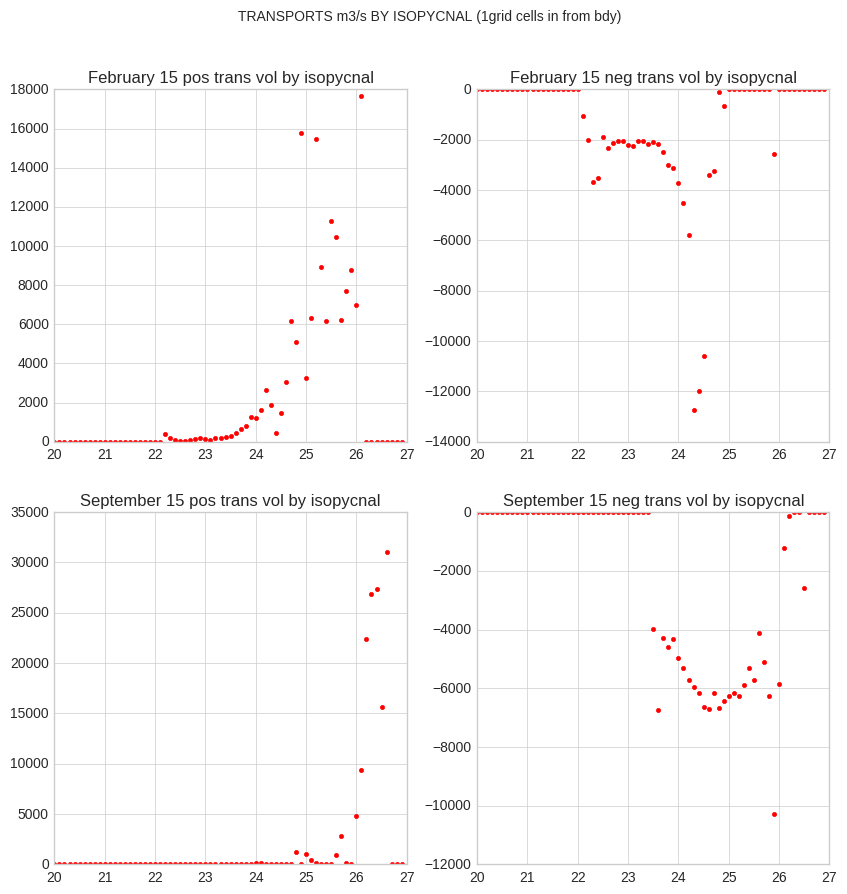

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,2,1)
ax.plot(pycnal_bins,Fpyc_post_sum,'r.')
ax.set_title('February 15 pos trans vol by isopycnal')
ax = fig.add_subplot(2,2,2)
ax.plot(pycnal_bins,Fpyc_negt_sum,'r.')
ax.set_title('February 15 neg trans vol by isopycnal')
ax = fig.add_subplot(2,2,3)
ax.plot(pycnal_bins,Spyc_post_sum,'r.')
ax.set_title('September 15 pos trans vol by isopycnal')
ax = fig.add_subplot(2,2,4)
ax.plot(pycnal_bins,Spyc_negt_sum,'r.')
ax.set_title('September 15 neg trans vol by isopycnal')

plt.suptitle('TRANSPORTS m3/s BY ISOPYCNAL ('+ str(dist_from_bdy) +
             'grid cells in from bdy)')

In [20]:
Fpyc_post_sum

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.11136937e+00, 3.78005046e+02, 1.70396120e+02,
       6.76274111e+01, 2.12140051e+01, 5.36933949e+01, 1.00090935e+02,
       1.34516373e+02, 1.65855566e+02, 1.29273414e+02, 8.58926748e+01,
       1.83175914e+02, 1.98289256e+02, 2.55368483e+02, 3.16381003e+02,
       4.44143727e+02, 6.57858727e+02, 8.27271627e+02, 1.24195011e+03,
       1.21412979e+03, 1.61472257e+03, 2.63957538e+03, 1.89305398e+03,
       4.64407213e+02, 1.45023570e+03, 3.07115320e+03, 6.18619494e+03,
       5.10001848e+03, 1.57646355e+04, 3.25750378e+03, 6.32315015e+03,
       1.54915657e+04, 8.91084201e+03, 6.19118750e+03, 1.12979845e+04,
      

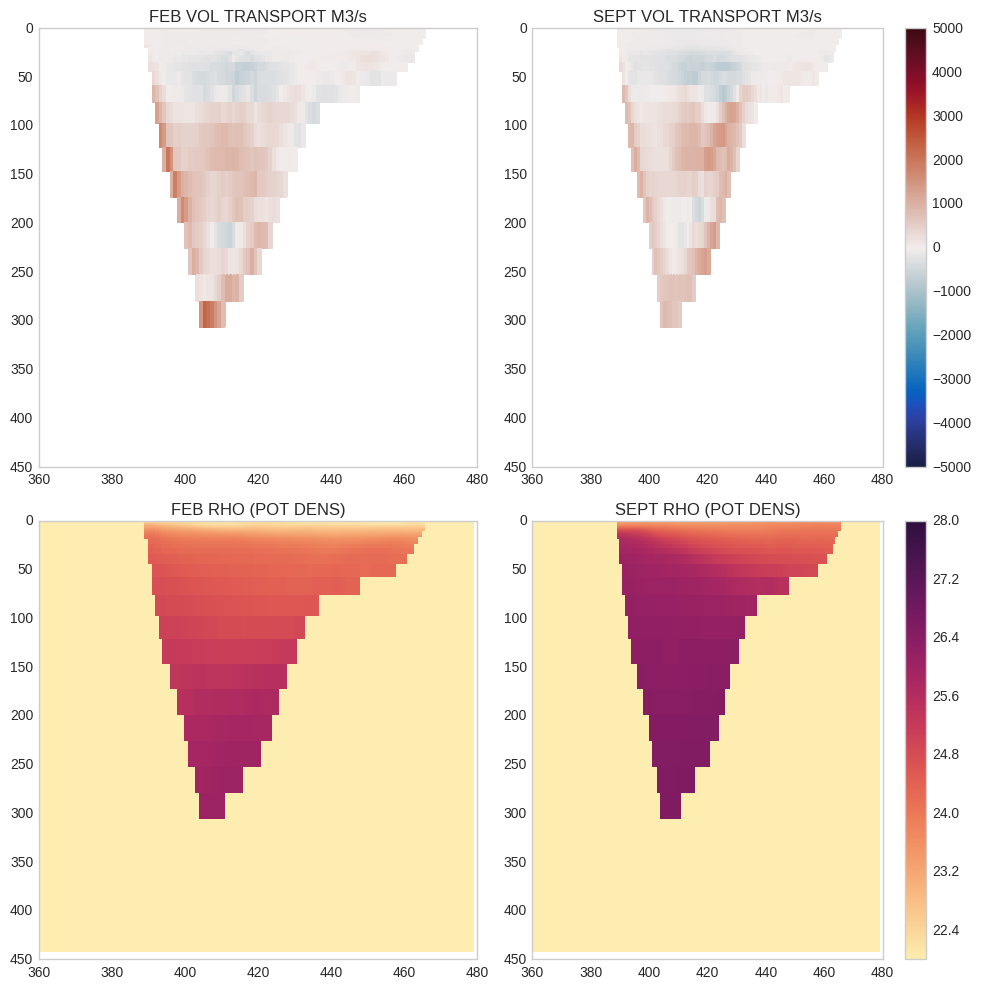

In [12]:
fig = plt.figure(figsize=(10,10))

for i in range(1,5):
    ax = fig.add_subplot(2,2,i)
    section_slice = np.arange(360,480)
    if i == 1:
        ax.invert_yaxis()
        sd = feb_vol[:,:]
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt, cmap = tcmap, vmin=-5000, vmax=5000 )
        ax.set_title('FEB VOL TRANSPORT M3/s')
    if i == 2:
        ax.invert_yaxis()
        sd = sep_vol[:,:]
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt, cmap = tcmap, vmin=-5000, vmax=5000 )
        cbar = fig.colorbar(mesh, ax=ax)
        ax.set_title('SEPT VOL TRANSPORT M3/s')        
    if i == 3:
        ax.invert_yaxis()
        sd = feb_rho[:,:]
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.matter
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt, cmap = tcmap, vmin=22, vmax=28 )
        ax.set_title('FEB RHO (POT DENS)')
    if i == 4:
        ax.invert_yaxis()
        sd = sep_rho[:,:]
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.matter
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt, cmap = tcmap, vmin=22, vmax=28 )
        cbar = fig.colorbar(mesh, ax=ax)
        ax.set_title('SEPT RHO (POT DENS)')
#plt.suptitle('Jan 1, 2016, DIC transport and rho', fontsize = 20)
fig.tight_layout()

    #plt.close()
plt.show()

In [13]:
UVEL_jdfmouth_BR_test = UVEL[:,:,:,dist_from_bdy]
UVEL_jdfmouth_BR_test = UVEL[:,:,:,dist_from_bdy]

In [14]:
d = 1
t_sample = sample_dates[d]
doy = doy_hc[t_sample]
tdate = dates_hc[t_sample]

t_testU_BR = nc.Dataset(files_hc_dian[t_sample])
UVEL = t_testU_BR['vozocrtx']
UVEL_jdfmouth_BR = UVEL[:,:,:,dist_from_bdy]
UVEL_jdfmouth2d_BR = np.squeeze(UVEL_jdfmouth_BR)


In [15]:
# test_uvel = (UVEL_jdfmouth2d_BR)
# print(UVEL_jdfmouth2d_BR[:,555:556])

In [16]:
# (UVEL_jdfmouth_BR_test[:,:,510:511])
# print(np.shape(feb_vol))
# print((feb_vol[:,155:156]))

In [17]:
# 27*440

In [18]:
np.nanmax(sep_rho)

26.559032338396264

In [19]:
print(pycnal_bins)
print(Spyc_post_sum)

[20.  20.1 20.2 20.3 20.4 20.5 20.6 20.7 20.8 20.9 21.  21.1 21.2 21.3
 21.4 21.5 21.6 21.7 21.8 21.9 22.  22.1 22.2 22.3 22.4 22.5 22.6 22.7
 22.8 22.9 23.  23.1 23.2 23.3 23.4 23.5 23.6 23.7 23.8 23.9 24.  24.1
 24.2 24.3 24.4 24.5 24.6 24.7 24.8 24.9 25.  25.1 25.2 25.3 25.4 25.5
 25.6 25.7 25.8 25.9 26.  26.1 26.2 26.3 26.4 26.5 26.6 26.7 26.8 26.9]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.36003871e+01
 2.55170331e+01 2.06523445e+01 3.65709767e+01 8.07731142e+01
 1.62756948e+02 1.14069437e+02 5.4